# Code

## Initialize

In [58]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as tsplot
import arch as arch

## Create database

In [298]:
#Create the Stock and Index price database 
st_date = dt.datetime(2019,1,1)
en_date = dt.datetime(2022,2,28)
stks_needed = ['JPM', 'SPY']#^GSPC
Stk_prices_list = []
flag = 0
for tc in list(stks_needed):
    if flag ==0 : 
        flag =1 
        Stk_prices_list.append(yf.Ticker(tc).history(start=st_date,end=en_date).index)
    Stk_prices_list.append(yf.Ticker(tc).history(start=st_date,end=en_date)['Close'].tolist())

#Create Database of stock prices
dataframe = pd.DataFrame(list(map(list, zip(*Stk_prices_list))),columns=['Date','JPM','SPY'])


## Analyze Data and Build Up Risk Measures

In [299]:
Scalar = 100
# Estimate both your symbol and SPY (independently) log return volatility using GARCH (1,1) from data Jan 1, 2019 to Dec 31, 2021
dataframe["JPM_Log_returns"] = [np.log(i) for i in dataframe["JPM"]]
dataframe["JPM_Log_returns"]=dataframe["JPM_Log_returns"].pct_change()*Scalar
dataframe["SPY_Log_returns"] = [np.log(i) for i in dataframe["SPY"]]
dataframe["SPY_Log_returns"]=dataframe["SPY_Log_returns"].pct_change()*Scalar

Vol_JPM = np.std(dataframe['JPM_Log_returns'])
Vol_SPY = np.std(dataframe['SPY_Log_returns'])

#Check plots for Log returns 
# plt.plot(dataframe['JPM_Log_returns'])
# plt.show()
# print(np.mean(dataframe['JPM_Log_returns']))
# plt.plot(dataframe['SPY_Log_returns'])
# plt.show()
# print(np.mean(dataframe['SPY_Log_returns']))
# tsplot.plot_acf(dataframe['JPM_Log_returns'][1:])
# plt.show()
# tsplot.plot_acf(dataframe['SPY_Log_returns'][1:])
# plt.show()
# tsplot.plot_pacf(dataframe['JPM_Log_returns'][1:])
# plt.show()
# tsplot.plot_pacf(dataframe['SPY_Log_returns'][1:])
# plt.show()

#Get Train data based on date
Train_end_date = dt.datetime(2021,12,31)
Train_data = dataframe.loc[dataframe['Date']<=Train_end_date]
Test_data = dataframe.loc[dataframe['Date']>Train_end_date]
Total_len = len(dataframe) 
Test_len = Total_len -len(Train_data)


#Fit Garch(1,1) model to data
JPM_Garch_model = arch.arch_model(Train_data["JPM_Log_returns"][1:],mean="Zero",vol='GARCH',p=1,q=1).fit()
SPY_Garch_model = arch.arch_model(Train_data["SPY_Log_returns"][1:],mean="Zero",vol='GARCH',p=1,q=1).fit()


Iteration:      1,   Func. Count:      5,   Neg. LLF: 3149.429475552561
Iteration:      2,   Func. Count:     14,   Neg. LLF: 972.9358862465979
Iteration:      3,   Func. Count:     20,   Neg. LLF: 3053.7828246490585
Iteration:      4,   Func. Count:     26,   Neg. LLF: 260.97946646214456
Iteration:      5,   Func. Count:     30,   Neg. LLF: 260.97804718235744
Iteration:      6,   Func. Count:     34,   Neg. LLF: 260.97804568513277
Iteration:      7,   Func. Count:     37,   Neg. LLF: 260.97804568525873
Optimization terminated successfully    (Exit mode 0)
            Current function value: 260.97804568513277
            Iterations: 7
            Function evaluations: 37
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 544.6373246584919
Iteration:      2,   Func. Count:     14,   Neg. LLF: 673.5652075185335
Iteration:      3,   Func. Count:     20,   Neg. LLF: 0.859632289960075
Iteration:      4,   Func. Count:     25,   Neg. LLF: -296.36050113

C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06058. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [300]:
#Model Statistics
print(JPM_Garch_model.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:        JPM_Log_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -260.978
Distribution:                  Normal   AIC:                           527.956
Method:            Maximum Likelihood   BIC:                           541.840
                                        No. Observations:                  756
Date:                Sat, Apr 09 2022   Df Residuals:                      756
Time:                        20:36:23   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.0045e-03  2.385e-03      2.517  1.183e-02 [1.

In [301]:
print(SPY_Garch_model.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:        SPY_Log_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                297.678
Distribution:                  Normal   AIC:                          -589.356
Method:            Maximum Likelihood   BIC:                          -575.472
                                        No. Observations:                  756
Date:                Sat, Apr 09 2022   Df Residuals:                      756
Time:                        20:36:23   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.8954e-03  5.993e-04      3.163  1.562e-03 [7.

In [302]:
#Forecast Garch Values Function
def Garch_Var(n, omega , alpha , beta, last_value, last_pct):
    vols = [last_value]*(n+1)
    returns = [last_pct]*(n+1)
    for i in range(1,n+1):
        vols[i] = (omega + (alpha * (returns[i-1]**2)) + (beta * vols[i-1]**2))**0.5
        returns[i] = vols[i]/Scalar * np.random.normal(0,1) # Assumung returns have mean 0 and volatility is coming from GARCH model
    return returns


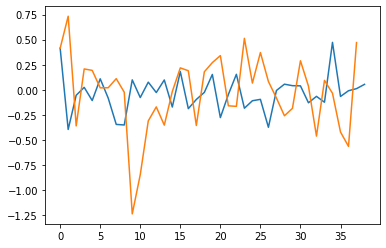

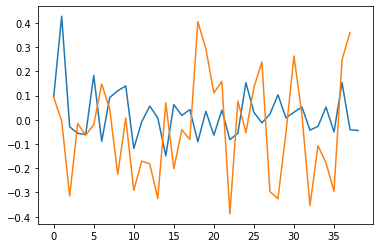

In [303]:
#Get Volatility Estimates from the model results for period Dec 31st 2021 to Feb 28 2022
Jpm_return_estimates = Garch_Var(Test_len, JPM_Garch_model.params[0],JPM_Garch_model.params[1],JPM_Garch_model.params[2],np.std(Train_data["JPM_Log_returns"][1:]), Test_data["JPM_Log_returns"].reset_index(drop=True)[0]/100)
plt.plot([i*100 for i in Jpm_return_estimates])# in Percentages
plt.plot(Test_data["JPM_Log_returns"].reset_index(drop=True))
plt.show()

Spy_return_estimates = Garch_Var(Test_len, SPY_Garch_model.params[0],SPY_Garch_model.params[1],SPY_Garch_model.params[2],np.std(Train_data["SPY_Log_returns"][1:]), Test_data["SPY_Log_returns"].reset_index(drop=True)[0]/100)
plt.plot([i*100 for i in Spy_return_estimates])
plt.plot(Test_data["SPY_Log_returns"].reset_index(drop=True))
plt.show()


In [307]:
#Correlation for Actual Data
Corr_actual = np.corrcoef(Train_data['JPM_Log_returns'][1:], Train_data['SPY_Log_returns'][1:])
print("Correlation estimate for actual returns: ",Corr_actual[0,1])

#Correlation for Estimated Data
Corr_Estimated = np.corrcoef(Jpm_return_estimates, Spy_return_estimates)
print("Correlation estimate for estmated returns: ",Corr_Estimated[0,1])


#Correlation for test Data
Corr_test = np.corrcoef(Test_data['JPM_Log_returns'], Test_data['SPY_Log_returns'])
print("Correlation estimate for test returns: ",Corr_test[0,1])

#Model does not perform so well

#Correlation for Full Data
Corr_test = np.corrcoef(dataframe['JPM_Log_returns'][1:], dataframe['SPY_Log_returns'][1:])
print("Correlation estimate for test returns: ",Corr_test[0,1])

Correlation estimate for actual returns:  0.7765643056364291
Correlation estimate for estmated returns:  -0.06778481551812185
Correlation estimate for test returns:  0.45034748559231186
Correlation estimate for test returns:  0.7659191212541699


## Portfolio Analysis

In [305]:
#Inital Asset Value 
Inv_Value_A = 1000000
Inv_Value_B = 1000000
Inv_Value_C = 2000000

#VaR percentile
VaR_Conf = 0.99
temp_percentile_99 = (Total_len - Test_len)*(1-VaR_Conf)
perc_99 = int(temp_percentile_99)
perc_weight = temp_percentile_99 - perc_99

### VaR Estimation

In [316]:
JPM_Hist_Sim = [i*Inv_Value_A for i in dataframe["JPM"].pct_change()[1:]]
JPM_Hist_Sim.sort()
JPM_VaR = perc_weight * JPM_Hist_Sim[perc_99 - 1] + (1-perc_weight) * JPM_Hist_Sim[perc_99]
JPM_ES = np.mean(JPM_Hist_Sim[0:perc_99])
print("one day 99% Var and ES for JPM: ",JPM_VaR, JPM_ES)

SPY_Hist_Sim = [i*Inv_Value_A for i in dataframe["SPY"].pct_change()[1:]]
SPY_Hist_Sim.sort()
SPY_VaR = perc_weight * SPY_Hist_Sim[perc_99 - 1] + (1-perc_weight) * SPY_Hist_Sim[perc_99]
SPY_ES = np.mean(SPY_Hist_Sim[0:perc_99])
print("one day 99% Var and ES for SPY: ",SPY_VaR, SPY_ES)

Port_Hist_Sim = [0.5*(SPY_Hist_Sim[i]+JPM_Hist_Sim[i]) for i in range(len(SPY_Hist_Sim))]
Port_Hist_Sim.sort()
Port_VaR = perc_weight * Port_Hist_Sim[perc_99 - 1] + (1-perc_weight) * Port_Hist_Sim[perc_99]
Port_ES = np.mean(Port_Hist_Sim[0:perc_99])
print("one day 99% Var and ES for the Portfolio: ",Port_VaR, Port_ES)

one day 99% Var and ES for JPM:  -62327.350037066135 -98637.81866914376
one day 99% Var and ES for SPY:  -44964.77592045908 -69318.62748785698
one day 99% Var and ES for the Portfolio:  -53646.06297876261 -83978.22307850036


### Back testing

In [335]:
#BackTesting 
BackTesting_Start_date = dt.datetime(2021,3,1)
Backtest_data = dataframe.loc[dataframe['Date']< BackTesting_Start_date,"JPM"]

Backtest_data = [i*Inv_Value_A for i in  Backtest_data.pct_change()[1:]]

Exceptions = [i for i in Backtest_data if i<=JPM_VaR]
[min(Backtest_data),JPM_VaR]
Exceptions

[-135455.2255672795,
 -82430.15475200121,
 -149648.77358426098,
 -105268.88932316203,
 -71239.3130258644,
 -62979.06387953534,
 -83443.3105519029]